In [1]:
# %matplotlib widget
%matplotlib inline
import os
import matplotlib.pyplot as plt
import numpy as np
import pyobs
import bison

%load_ext autoreload
%autoreload 1

%aimport GEVP_pyobs

# plt.rcParams.update({
#     "text.usetex"      : True,
#     "font.family"      : "Helvetica",
#     "mathtext.fontset" : "dejavuserif"
# })
plt.rcParams.update({
    "axes.axisbelow"   : True,
})

In [3]:
### Loading data file ###
data = bison.load("Cnfgs_measurement/WF-slices_beta617_lat32x64.dat")

[Bison] : Reading file Cnfgs_measurement/WF-slices_beta617_lat32x64.dat
[Bison] : File created by gmorandi at ampere on Tue Dec 19 00:02:04 2023
[Bison] : Read 283.844 MB at 530.181 MB/s


In [3]:
##############################
### General run parameters ###
##############################
beta      =  data['beta coupling']
L1, L2, L3, T = data['Lattice']
V         =  L1 * L2 * L3 * T
D         =  4
Ns        =  data['Number of steps of OMF4 integrator']
tauMD     =  data['Length of each MD trajectory']
Ntraj     =  data['MD trajectories']
MC_step   =  data['MC measure step']
eps_WF    =  data['epsilon WF']
WF_evol   =  data['WF evolutions from t = 0']
WF_step   =  data['WF measure step']
Nwf       =  WF_evol // WF_step + 1
Nc_run    = Ntraj // MC_step

Ncnfg0 = 0
Nh     = 0
for key in data:
    if key.startswith('Configuration'):
        Ncnfg0 += 1
    if key.startswith('MC History'):
        Nh += 1

print(f"\n Lattice                =  [{L1}x{L2}x{L3}x{T}]")
print(f" Lattice volume         =  {V}")
print(f" beta                   =  {beta}")
print(f" Steps of OMF4          =  {Ns}")
print(f" tau MD                 =  {tauMD}")
print(f" MD trajectories        =  {Ntraj}")
print(f" MC interval between measurements  =  {MC_step}")
print(f" epsilon of Wilson Flow =  {eps_WF}")
print(f" Wilson Flow evolutions =  {WF_evol}")
print(f" Wilson Flow steps between measurements =  {WF_step}\n")

print(f" Measured flow times:")
print(f" from t = {eps_WF * WF_step * 0:.2f} to t = {eps_WF * WF_step * (Nwf - 1):.2f}")
print(f" total measurements along flow time = {Nwf}")
# print(*(f" t = {eps_WF * WF_step * i:.2f}" for i in range(Nwf)), sep='\n')

Ntherm0 = 200
skip = (5 * 20 * MC_step - Ntherm0) // MC_step

Ncnfg = Ncnfg0 - skip
print(f"\n Total configs. = {Ncnfg} (after removing initial due to therm.)")


 Lattice                =  [32x32x32x64]
 Lattice volume         =  2097152
 beta                   =  6.17
 Steps of OMF4          =  8
 tau MD                 =  2.0
 MD trajectories        =  200
 MC interval between measurements  =  10
 epsilon of Wilson Flow =  0.02
 Wilson Flow evolutions =  300
 Wilson Flow steps between measurements =  5

 Measured flow times:
 from t = 0.00 to t = 6.00
 total measurements along flow time = 61

 Total configs. = 3080 (after removing initial due to therm.)


In [4]:
########################################################
### Loading history run and observables measurements ###
########################################################
WF_EClov = np.zeros((Ncnfg0, Nwf, T))
WF_Plaq  = np.zeros((Ncnfg0, Nwf, T))
WF_Q     = np.zeros((Ncnfg0, Nwf, T))

for i in range(Ncnfg0):
    WF_EClov[i,:,:] = data[f'Configuration {i+1}']['E_Clov']
    WF_Plaq[i,:,:]  = data[f'Configuration {i+1}']['Plaquette']
    WF_Q[i,:,:]     = data[f'Configuration {i+1}']['Q']

t_WF  = np.array([eps_WF * WF_step * i for i in range(Nwf)])
t_min = np.ceil(np.sqrt(8*t_WF)).astype('int32')
print(f"Wilson flow times  :\n{t_WF}\n")
print(f"Corresponding minimum physical distances, i.e. ~ int(sqrt(8 t_WF))  :\n{t_min}")

Wilson flow times  :
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.  5.1 5.2 5.3
 5.4 5.5 5.6 5.7 5.8 5.9 6. ]

Corresponding minimum physical distances, i.e. ~ int(sqrt(8 t_WF))  :
[0 1 2 2 2 2 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]


In [5]:
###############################################################
### Compute <E(t)>_Clov for 0 <= t <= T-1 and for each t_WF ###
EClov_t = []
EClov   = []  
for i0 in range(Nwf):
    EClov_t.append(pyobs.observable(description=f'<E(t)> Clov at t_WF = {t_WF[i0]:.2f}'))
    EClov_t[-1].create('Ensemble A', (WF_EClov[skip:,i0,:] * T/V).flatten(), shape=(T,))
    EClov.append(pyobs.sum(EClov_t[-1]) / T)
    print(f"(t_WF = {t_WF[i0]:.2f}) :    <E(t)>_Clov = {EClov_t[-1]}                      <E>_Clov = {EClov[-1]}")
###############################################################

(t_WF = 0.00) :    <E(t)>_Clov = 1.955259(60)	1.955297(62)	1.955429(58)	1.955366(57)	1.955355(58)	1.955405(61)	1.955416(58)	1.955254(56)	1.955280(58)	1.955363(60)	1.955396(58)	1.955415(62)	1.955258(57)	1.955316(55)	1.955389(61)	1.955281(65)	1.955354(61)	1.955323(60)	1.955358(61)	1.955335(60)	1.955287(58)	1.955355(58)	1.955373(57)	1.955280(61)	1.955336(59)	1.955326(58)	1.955329(57)	1.955403(59)	1.955312(62)	1.955314(59)	1.955210(61)	1.955182(58)	1.955201(58)	1.955271(58)	1.955266(59)	1.955321(57)	1.955209(56)	1.955180(63)	1.955277(58)	1.955261(58)	1.955229(61)	1.955330(59)	1.955239(58)	1.955274(58)	1.955362(62)	1.955260(59)	1.955276(58)	1.955284(60)	1.955246(57)	1.955299(60)	1.955260(57)	1.955380(62)	1.955320(60)	1.955382(56)	1.955402(60)	1.955358(58)	1.955298(64)	1.955348(61)	1.955389(63)	1.955366(64)	1.955309(65)	1.955389(55)	1.955289(58)	1.955332(60)
                      <E>_Clov = 1.955315(10)

(t_WF = 0.10) :    <E(t)>_Clov = 1.373033(69)	1.373090(74)	1.373222(66)	1.373136(67)	1.3

In [6]:
#############################################################
### Compute <Plaq(t)> for 0 <= t <= T-1 and for each t_WF ###
Plaq_t = []
Plaq   = []
for i0 in range(Nwf):
    Plaq_t.append(pyobs.observable(description=f'<Plaq(t)> at t_WF = {t_WF[i0]:.2f}'))
    Plaq_t[-1].create('Ensemble A', (WF_Plaq[skip:,i0,:] * T/V).flatten(), shape=(T,))
    Plaq.append(pyobs.sum(Plaq_t[-1]) / T)
    print(f"(t_WF = {t_WF[i0]:.2f}) :    <Plaq(t))> = {Plaq_t[-1]}                       <Plaq> = {Plaq[-1]}")
#############################################################

(t_WF = 0.00) :    <Plaq(t))> = 0.610884(11)	0.610863(10)	0.610836(10)	0.610848(10)	0.610871(11)	0.610852(11)	0.610852(11)	0.610851(11)	0.610867(11)	0.610865(11)	0.610866(11)	0.610860(11)	0.610894(11)	0.610872(10)	0.610856(10)	0.610873(11)	0.610866(11)	0.610865(11)	0.610875(10)	0.610865(10)	0.610857(11)	0.6108729(100)	0.610866(11)	0.610849(11)	0.610880(11)	0.610862(11)	0.610848(10)	0.610856(11)	0.610877(11)	0.610874(11)	0.610886(11)	0.610876(10)	0.610870(11)	0.610884(10)	0.610865(11)	0.610873(11)	0.610879(11)	0.610863(11)	0.610869(11)	0.610861(10)	0.610884(10)	0.610859(11)	0.610882(11)	0.610854(12)	0.610850(11)	0.610874(11)	0.610866(11)	0.610872(11)	0.610866(10)	0.610861(11)	0.610879(11)	0.610866(10)	0.610861(11)	0.610848(11)	0.610857(10)	0.610867(11)	0.610853(11)	0.610859(11)	0.610861(11)	0.610861(11)	0.610873(11)	0.610851(10)	0.610879(11)	0.610866(11)
                       <Plaq> = 0.6108656(16)

(t_WF = 0.10) :    <Plaq(t))> = 0.8364779(80)	0.8364610(76)	0.8364475(74)	0.8364580(79)

In [7]:
##########################################################
### Compute <q(t)> for 0 <= t <= T-1 and for each t_WF ###
Q_t = []
Q   = []
for i0 in range(Nwf):
    Q_t.append(pyobs.observable(description=f'<q(t)> at t_WF = {t_WF[i0]:.2f}'))
    Q_t[-1].create('Ensemble A', (WF_Q[skip:,i0,:] * T/V).flatten(), shape=(T,)) 
    Q.append(pyobs.sum(Q_t[-1]) / T)
    print(f"(t_WF = {t_WF[i0]:.2f}) :    <q(t)> = {Q_t[-1]}                      <Q> = {Q[-1]}")
##########################################################

(t_WF = 0.00) :    <q(t)> = 1.6(1.1)	-0.6(1.1)	0.2(1.0)	1.0(1.1)	1.1(1.1)	0.1(1.0)	-1.1(1.1)	0.0(1.1)	-0.3(1.2)	1.4(1.0)	-1.69(100)	0.2(1.0)	-0.5(1.0)	-2.2(1.1)	0.6(1.1)	0.3(1.2)	0.2(1.1)	1.4(1.0)	0.8(1.1)	1.0(1.1)	-0.8(1.1)	-0.3(1.1)	0.1(1.1)	1.1(1.1)	0.8(1.1)	0.0(1.1)	0.3(1.1)	-1.6(1.1)	0.7(1.2)	0.6(1.1)	0.1(1.0)	0.6(1.1)	-1.2(1.1)	-0.0(1.1)	-0.1(1.1)	-1.8(1.1)	-0.8(1.0)	-0.4(1.0)	-2.6(1.1)	-1.2(1.1)	-0.1(1.1)	-2.1(1.1)	-1.5(1.1)	0.4(1.1)	-1.8(1.1)	2.4(1.1)	-2.8(1.0)	-1.0(1.1)	-0.5(1.0)	1.4(1.1)	-1.4(1.0)	1.6(1.0)	0.8(1.1)	-0.4(1.1)	0.1(1.1)	-1.3(1.1)	-1.5(1.0)	-0.7(1.0)	0.88(99)	-0.2(1.1)	1.7(1.1)	1.1(1.1)	-1.4(1.1)	0.3(1.2)
                      <Q> = -0.13(14)

(t_WF = 0.10) :    <q(t)> = 2.3(1.0)	-0.2(1.0)	0.3(1.1)	1.2(1.0)	1.4(1.0)	0.74(97)	-0.5(1.1)	0.4(1.0)	-0.6(1.1)	0.04(99)	-2.13(95)	0.51(95)	-0.60(97)	-2.7(1.0)	0.8(1.0)	0.9(1.1)	-0.07(98)	1.92(99)	0.61(97)	0.2(1.0)	-1.0(1.0)	-1.1(1.1)	0.2(1.0)	1.6(1.0)	1.34(97)	-0.12(98)	0.7(1.1)	-1.4(1.0)	1.3(1.1)	0.8(1.0)	0.42(96)	1.49(98

In [8]:
#####################################################
### Computing delta's of <q(t)> and dq(t)dq(t+t') ###
dq_t    = np.zeros((Nwf, Ncnfg, T))
dqdq_tt = np.zeros((Nwf, Ncnfg, T, T))

for i0 in range(Nwf):
    dq_t[i0,:,:] = Q_t[i0].delta['Ensemble A:0'].delta.T

for tp in range(T):
    dqdq_tt[:,:,tp,:] = dq_t * np.roll(dq_t, -tp, axis=2)
#####################################################

In [9]:
##########################################################################
### Computation of Chi^Tmax(t) = < sum_{t'=0}^{Tmax} q(t)q(t+t') >_c  ###
Tmax1, Tmax2 = 2, T-1   # 1 small
Chi_Tmax1 = []
# Chi_Tmax2 = []
for i0 in range(Nwf):
    ### Tmax1 ###
    Chi_Tmax1.append(pyobs.observable(description=f"Chi^{Tmax1}(t) for t_WF = {t_WF[i0]:.2f}"))
    Chi_Tmax1[-1].create('Ensemble A', np.sum(dqdq_tt[i0,:,:Tmax1+1,:], axis=1).flatten(), shape=(T,))
    Chi_Tmax1[-1] /= T
    print(f"t_WF = {t_WF[i0]:.2f}  :  Chi^{Tmax1}(t) = {Chi_Tmax1[-1]}")

    # ### Tmax2 ###
    # Chi_Tmax2.append(pyobs.observable(description=f"Chi^{Tmax2}(t) for t_WF = {t_WF[i0]:.2f}"))
    # Chi_Tmax2[-1].create('Ensemble A', np.sum(dqdq_tt[i0,:,:Tmax2+1,:], axis=1).flatten(), shape=(T,))
    # Chi_Tmax2[-1] /= T
    # print(f"t_WF = {t_WF[i0]:.2f}  :  Chi^{Tmax1}(t) = {Chi_Tmax1[-1]}               Chi^{Tmax2}(t) = {Chi_Tmax2[-1]}")
##########################################################################

t_WF = 0.00  :  Chi^2(t) = 46.1(1.8)	46.7(1.8)	48.1(1.9)	49.7(1.7)	52.4(1.9)	48.5(1.7)	51.4(1.9)	47.6(1.7)	46.2(1.8)	49.8(1.7)	47.7(1.8)	47.2(1.7)	50.6(1.9)	47.5(1.6)	48.1(1.8)	48.3(1.8)	49.0(1.8)	49.0(1.8)	47.5(1.8)	52.9(1.9)	49.1(1.8)	46.6(1.7)	53.2(1.9)	50.2(1.8)	48.8(1.7)	47.2(1.8)	51.6(2.1)	48.0(1.8)	48.4(1.7)	47.9(1.7)	50.5(1.9)	50.9(1.9)	46.9(1.8)	49.9(1.9)	49.0(1.9)	51.1(1.9)	47.4(1.8)	47.5(1.9)	47.7(1.8)	47.7(1.9)	47.1(1.6)	47.9(1.8)	52.1(2.0)	46.0(1.8)	48.1(1.7)	50.9(1.9)	47.9(1.8)	48.0(1.8)	47.0(1.7)	52.0(1.8)	46.3(1.6)	47.9(1.8)	48.0(1.9)	51.1(1.9)	47.1(1.7)	52.3(1.8)	49.2(1.9)	47.1(1.7)	47.8(2.0)	50.2(1.9)	49.4(1.9)	47.2(1.9)	50.8(1.9)	49.7(1.8)

t_WF = 0.10  :  Chi^2(t) = 35.3(1.4)	35.3(1.4)	33.8(1.4)	35.6(1.4)	38.7(1.3)	34.1(1.3)	36.7(1.5)	36.1(1.4)	36.0(1.4)	34.8(1.4)	35.6(1.3)	35.0(1.4)	35.5(1.4)	35.9(1.3)	35.8(1.4)	34.9(1.4)	34.4(1.4)	35.1(1.4)	33.3(1.3)	37.1(1.3)	36.0(1.4)	35.1(1.3)	36.5(1.5)	35.8(1.3)	35.4(1.4)	33.6(1.4)	37.5(1.5)	35.1(1.3)	36.4(1.5)	35.8(1.3)	37.6(

We have just calculated observables 
$$
    O_0(t) = \langle \widetilde{E}(t) \rangle_\mathrm{Clov} \, , \qquad O_1(t) = \langle \widetilde{P}(t) \rangle \, , \qquad  O_2(t) \equiv \chi^{T_\mathrm{max}}(t) = \frac{1}{V} \sum_{t'=0}^{T_\mathrm{max}} \langle \delta \widetilde{q}(t) \delta \widetilde{q}(t+t') \rangle \, , \quad \text{for} \quad t = 0, \ldots, T-1 \, ,
$$
where "$\widetilde{\bullet}$" means zero-momentum projection along direction $T$, i.e. $\widetilde{E}(t) = \sum_{\mathbf{x}} E(t, \mathbf{x})$ (and the same for $\widetilde{q}(t)$ and $\widetilde{P}(t)$). 

We are interested in the following correlator
$$
    C_{ij}(t) = \langle \delta O_i(t) \delta O_j(0) \rangle \, , \quad \text{for} \quad (i, j) = (0, 1, 2) \, , \text{ and } \, t = 0, \ldots, T-1
$$
where $\delta^k O_i(t) \equiv O_i(t)^k - \langle O_i(t) \rangle$ is the fluctuation of observable $O_i(t)$ at the $k$-th configuration; it's clear that $\langle \delta^k O_i(t) \rangle = \langle \delta O_i(t) \rangle = 0$. Labels $(i,j)$ take also into account the possible different Wilson flow times of $O_0$, $O_1$ and $O_2$. 
Possibles choices of Wilson flow times that have been considered in the following are:
- $t_\mathrm{WF} \simeq 1$ for $O_0(t)$. 
- $t_\mathrm{WF} \simeq 0$ for $O_1(t)$, $O_2(t)$ ($T_\mathrm{max} = 2$).

In [10]:
d_O = np.zeros((3, Nwf, Ncnfg, T))
for i0 in range(Nwf):
    d_O[0,i0] = EClov_t[i0].delta['Ensemble A:0'].delta.T           # O_0
    d_O[1,i0] = Plaq_t[i0].delta['Ensemble A:0'].delta.T            # O_1
    d_O[2,i0] = Chi_Tmax1[i0].delta['Ensemble A:0'].delta.T         # O_2
    # d_O[3,i0] = Chi_Tmax2[i0].delta['Ensemble A:0'].delta.T         # O_3

We use the GEVP method by solving the following eigenvalue equation
$$
    C(t) v_i(t,t_0) = \lambda_i(t,t_0) C(t_0) v_i(t,t_0) \, , \quad t > t_0 \, ,
$$
where $i = (0,1,2,3)$ and $t, t_0$ are physical time distances; the dependence of the Wilson flow time in $C$ is understood. Inverting the matrix at RHS yields
$$
    \left[ C^{-1}(t_0) C(t) \right] v_i(t,t_0) = \lambda_i(t,t_0) v_i(t,t_0) \, ,
$$
hence the routine <code>pyobs.linalg.eigLR(...)</code> can be applied to diagonalize the matrix $C^{-1}(t_0) C(t)$, which is in general a $4 \times 4$ non-symmetric matrix (fixed $t, t_0$ and $t_\mathrm{WF}$). On the other hand, we can symmetrize $C(t)$ noticing that $C_{ij}(t) = C_{ji}(T-t)$, therefore we replace
$$
    C_{ij}(t) \rightarrow \frac{1}{2} \{ C_{ij}(t) + C_{ij}(T-t) \} \, , \quad \text{for} \quad t = 1, \ldots, \frac{T}{2} - 1 \, ;
$$

On top of that, the eigenvalue system above can be rewritten as 
$$
    \left[ C^{-1/2}(t_0) C(t) C^{-1/2}(t_0) \right] v_i'(t,t_0) = \lambda_i(t,t_0) v_i'(t,t_0) \, , \quad \text{with} \quad v_i'(t,t_0) = C^{1/2}(t_0) v_i(t,t_0) \, ;
$$
since now $C(t)$ is symmetric we can make use of <code>pyobs.linalg.eig(...)</code> to diagonalize $C^{-1/2}(t_0) C(t) C^{-1/2}(t_0)$, which is obviously symmetric as well. 

The eigenvalues of both the systems are the same and they are related to the energy differences through
$$
    E_n(t, t_0) \simeq \frac{1}{a} \log \frac{\lambda_n(t, t_0)}{\lambda_n(t+a, t_0)} \, \quad \text{or} \quad E_n(t, t_0) \simeq - \frac{1}{t-t_0} \log \lambda_n(t, t_0) \, . 
$$

The routine <code>GEVP</code> of library <code>GEVP_pyobs</code> performs exactly the computation above. It extracts the ground state $E_0(t,t_0)$ following different approaches according to the choices of $t, t_0$:
- Choose $t-t_0 = \mathrm{const}$ and span all possible $t,t_0$ values. This is done by passing <code>t0=-1</code> and a particular <code>const</code>. In this case the ground state is computed using the single $\lambda_0(t, t_0)$.
- Fix $t_0$ and span $t$ values. This is done by passing <code>t0</code> in between 0 and $T/2-2$. By choosing <code>case='ratio'</code> the energy is calculated from the ratio of the eigenvalues, instead with <code>case='single'</code> only a single eigenvalue is used. 

The dashed vertical lines in the following plots indicates the physical times $t$ s.t. $t \geqslant \sqrt{8 t_\mathrm{WF}}$. 


Studies to be done: we removed the operator $O_3$ because it is non-local; perform the following analysis:
- let's study the 3x3 GEVP fixing $t_0 = 0,1,2,3$ and spanning only $t$. Fixed operators.
- fix $t_0 = 0$ and study several operators by changing their flow times. Example: keep ops 1,2 and change flow time of 3 from small to big. Focus on the 2 values 1.1 e 0.3

Analyze both approaches: fix $t_0$ and fix $t-t_0 = 1,2$ (not 3 no signal). 

In [13]:
###############################################################
### Choose Wilson flow times for dO_i and compute dO_i dO_j ###
tW0, tW1, tW2 = 1.10, 0.30, 0.30
iW0, iW1, iW2 = int(np.around(tW0 / (WF_step * eps_WF))), int(np.around(tW1 / (WF_step * eps_WF))), int(np.around(tW2 / (WF_step * eps_WF)))
pairs = [(0, iW0), (1, iW1), (2, iW2)]    # labels for pairs (observable, corresponding t_WF)
Noss = len(pairs)

dOidOj = np.zeros((Ncnfg, Noss, Noss, T))
for tp in range(T):
    # print(f"t = {tp}")  
    for (i, WF1) in pairs:
        row = pairs.index((i, WF1))
        for (j, WF2) in pairs:
            col = pairs.index((j, WF2))
            # print(f"        :  row = {row}, ({i}, {t_WF[WF1]:.2f});  col = {col}, ({j}, {t_WF[WF2]:.2f})")
            dOidOj[:,row,col,tp] = np.mean(d_O[i,WF1] * np.roll(d_O[j,WF2], -tp, axis=1).conj(), axis=1)

##############################
### Create C_ij observable ###
obs = pyobs.observable(description=f'<dO_i(t)dO_j(0)> for (i, t_WF) = [(0, {tW0:.2f}), (1, {tW1:.2f}), (2, {tW2:.2f})]')
obs.create('Ensemble A', dOidOj.flatten(), shape=(Noss, Noss, T))   
C = pyobs.concatenate(obs[:,:,0], (obs[:,:,1:T//2]+obs[:,:,:T//2:-1])*0.5, axis=2)      # C.shape = (Noss, Noss, T//2)

####################
### Perform GEVP ###
# case1 = 'single'
# t_t0_0s, Eg_t0_0s = GEVP_pyobs.GEVP(C, t0=0, const=1, case=case1)
# t_t0_1s, Eg_t0_1s = GEVP_pyobs.GEVP(C, t0=1, const=1, case=case1)   # no signal for t0 = 2,3

case2 = 'ratio'
t_t0_0r, Eg_t0_0r = GEVP_pyobs.GEVP(C, t0=0, const=1, case=case2)
t_t0_1r, Eg_t0_1r = GEVP_pyobs.GEVP(C, t0=1, const=1, case=case2)   # no signal for t0 = 2,3

# tmin012 = max(t_min[iW0], t_min[iW1], t_min[iW2])

# ####################
# ### Plot results ###
# Eg_0s, dEg_0s = Eg_t0_0s.error()
# Eg_1s, dEg_1s = Eg_t0_1s.error()

# Eg_0r, dEg_0r = Eg_t0_0r.error()
# Eg_1r, dEg_1r = Eg_t0_1r.error()

# fig, ax = plt.subplots(figsize=(16, 9))

# plt.subplots_adjust(top    = 0.95)
# plt.subplots_adjust(bottom = 0.05)
# plt.subplots_adjust(left   = 0.05)
# plt.subplots_adjust(right  = 0.95)

# box = dict(boxstyle="round", color='#d9d9d9')
# fsize = 14
# ymin = 0
# ymax = 1
 
# plt.suptitle(rf"$3 \times 3$ GEVP operators $O_0(t_\mathrm{{WF}}={tW0:.2f})$, $O_1(t_\mathrm{{WF}}={tW1:.2f})$ and $O_2(t_\mathrm{{WF}}={tW2:.2f})$", fontsize=fsize)
# plt.title(rf"Fixing $t_0$ and spanning $t$", pad=15, fontsize=fsize)

# ax.errorbar(t_t0_0s, Eg_0s, yerr=dEg_0s, marker='s', markersize=5, linestyle='', capsize=2.5, label=rf'$t_0 = 0$, {case1}', color='red',  linewidth=1.6)
# ax.errorbar(t_t0_1s+0.12, Eg_1s, yerr=dEg_1s, marker='D', markersize=4.5, linestyle='', capsize=2.5, label=rf'$t_0 = 1$, {case1}', color='blue', linewidth=1.6)
# ax.errorbar(t_t0_0r+0.24, Eg_0r, yerr=dEg_0r, marker='o', markersize=5, linestyle='', capsize=2.5, label=rf'$t_0 = 0$, {case2}', color='green',  linewidth=1.6)
# ax.errorbar(t_t0_1r+0.36, Eg_1r, yerr=dEg_1r, marker='+', markersize=6, linestyle='', capsize=2.5, label=rf'$t_0 = 1$, {case2}', color='orange', linewidth=1.6)

# ax.vlines(x = tmin012, ymin = 0, ymax = ymax, colors = 'black',  linewidth=1.5, linestyles='--')
# ax.annotate(rf"$t_\mathrm{{min}}$", (tmin012, ymax), xytext=(tmin012, ymax-0.05*ymax), ha='center', bbox=box, fontsize=fsize-2)
# ax.set_ylabel(rf'$E_0(t, t_0)$', rotation=90, labelpad=10, fontsize=fsize)
# ax.set_xlabel(rf'$t/a$', fontsize=fsize)

# ax.legend(loc='best', fontsize=fsize)

# plt.yticks(fontsize=fsize)
# plt.xticks(fontsize=fsize)
# #plt.xlim([-0.1, T // 2 + 0.5])
# plt.ylim([ymin, ymax])
# #ax.set_yscale('log')
# ax.grid(linestyle = '--', linewidth = 0.75)

# fig.tight_layout()

# print(f"Result for 3x3 GEVP; Fixing t0 and spanning t:\n")
# print(f"case = '{case1}'  :  t0 = 0,  E_0 = {Eg_t0_0s}")
# print(f"                 :  t0 = 1,  E_0 = {Eg_t0_1s}")
# print(f"case = '{case2}'   :  t0 = 0,  E_0 = {Eg_t0_0r}")
# print(f"                 :  t0 = 1,  E_0 = {Eg_t0_1r}")

In [14]:
Eg_t0_0r, Eg_t0_1r

(nan(64)	nan(32)	nan(1.7), nan(27)	nan(1.8))

Result for 3x3 GEVP; Fixing t0 and spanning t:

case = 'single'  :  t0 = 0,  E_0 = 0.1658(12)	0.3005(26)	0.3928(45)	0.4474(71)	0.477(11)	0.492(16)	0.494(23)	0.487(30)	0.482(41)	0.490(65)	0.50(11)	nan(61)	nan(63)	0.345(38)	0.314(30)	0.317(44)	0.326(69)	nan(34)	nan(25)	nan(24)	nan(31)	0.234(29)	nan(48)	nan(37)	nan(28)	0.210(33)	nan(14)	0.207(48)	nan(28)	nan(24)

                 :  t0 = 1,  E_0 = 0.4287(41)	0.4974(63)	0.5313(92)	0.545(13)	0.549(19)	0.544(27)	0.530(35)	0.516(47)	nan(76)	0.53(12)	nan(65)	nan(67)	0.342(39)	0.309(31)	0.318(46)	0.327(72)	0.264(33)	0.224(20)	nan(26)	nan(32)	0.224(30)	nan(48)	nan(37)	nan(27)	0.196(31)	0.201(39)	0.202(45)	nan(27)	nan(21)

case = 'ratio'   :  t0 = 0,  E_0 = 0.4351(40)	0.5775(85)	0.611(16)	0.597(28)	0.565(47)	0.506(72)	0.44(10)	0.44(16)	0.57(32)

                 :  t0 = 1,  E_0 = 0.5661(86)	0.599(16)	0.588(28)	0.563(48)	0.518(76)	0.44(10)	0.42(17)	nan(80)	nan(1.4)	nan(1.4)



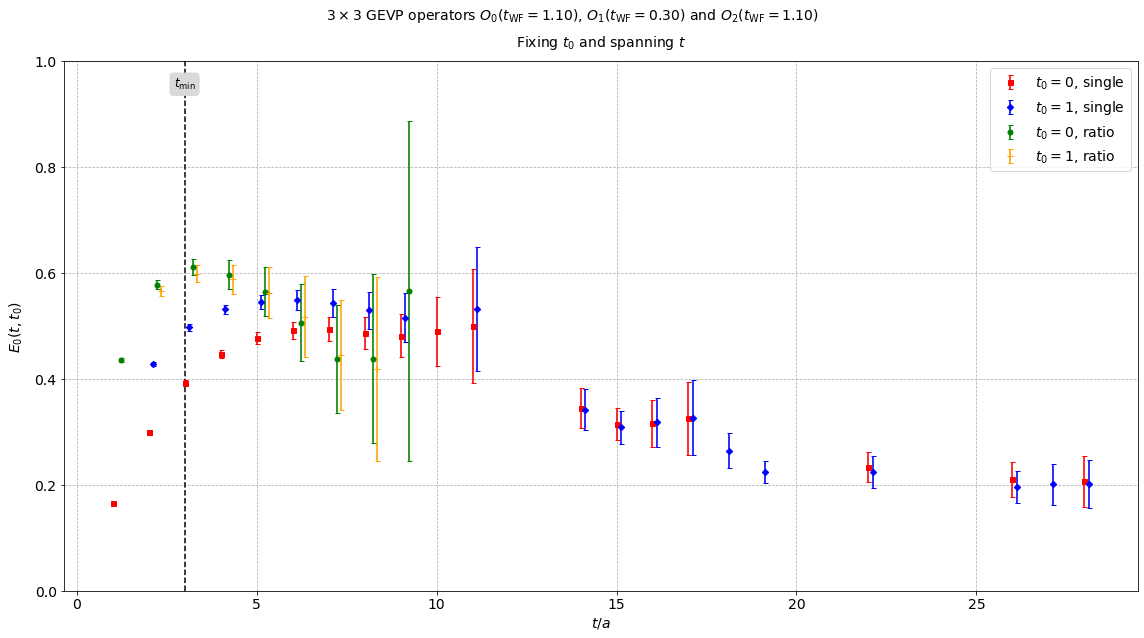

In [12]:
###############################################################
### Choose Wilson flow times for dO_i and compute dO_i dO_j ###
tW0, tW1, tW2 = 1.10, 0.30, 1.10
iW0, iW1, iW2 = int(np.around(tW0 / (WF_step * eps_WF))), int(np.around(tW1 / (WF_step * eps_WF))), int(np.around(tW2 / (WF_step * eps_WF)))
pairs = [(0, iW0), (1, iW1), (2, iW2)]    # labels for pairs (observable, corresponding t_WF)
Noss = len(pairs)

dOidOj = np.zeros((Ncnfg, Noss, Noss, T))
for tp in range(T):
    # print(f"t = {tp}")  
    for (i, WF1) in pairs:
        row = pairs.index((i, WF1))
        for (j, WF2) in pairs:
            col = pairs.index((j, WF2))
            # print(f"        :  row = {row}, ({i}, {t_WF[WF1]:.2f});  col = {col}, ({j}, {t_WF[WF2]:.2f})")
            dOidOj[:,row,col,tp] = np.mean(d_O[i,WF1] * np.roll(d_O[j,WF2], -tp, axis=1).conj(), axis=1)

##############################
### Create C_ij observable ###
obs = pyobs.observable(description=f'<dO_i(t)dO_j(0)> for (i, t_WF) = [(0, {tW0:.2f}), (1, {tW1:.2f}), (2, {tW2:.2f})]')
obs.create('Ensemble A', dOidOj.flatten(), shape=(Noss, Noss, T))   
C = pyobs.concatenate(obs[:,:,0], (obs[:,:,1:T//2]+obs[:,:,:T//2:-1])*0.5, axis=2)      # C.shape = (Noss, Noss, T//2)

####################
### Perform GEVP ###
case1 = 'single'
t_t0_0s, Eg_t0_0s = GEVP_pyobs.GEVP(C, t0=0, const=1, case=case1)
t_t0_1s, Eg_t0_1s = GEVP_pyobs.GEVP(C, t0=1, const=1, case=case1)   # no signal for t0 = 2,3

case2 = 'ratio'
t_t0_0r, Eg_t0_0r = GEVP_pyobs.GEVP(C, t0=0, const=1, case=case2)
t_t0_1r, Eg_t0_1r = GEVP_pyobs.GEVP(C, t0=1, const=1, case=case2)   # no signal for t0 = 2,3

tmin012 = max(t_min[iW0], t_min[iW1], t_min[iW2])

####################
### Plot results ###
Eg_0s, dEg_0s = Eg_t0_0s.error()
Eg_1s, dEg_1s = Eg_t0_1s.error()

Eg_0r, dEg_0r = Eg_t0_0r.error()
Eg_1r, dEg_1r = Eg_t0_1r.error()

fig, ax = plt.subplots(figsize=(16, 9))

plt.subplots_adjust(top    = 0.95)
plt.subplots_adjust(bottom = 0.05)
plt.subplots_adjust(left   = 0.05)
plt.subplots_adjust(right  = 0.95)

box = dict(boxstyle="round", color='#d9d9d9')
fsize = 14
ymin = 0
ymax = 1
 
plt.suptitle(rf"$3 \times 3$ GEVP operators $O_0(t_\mathrm{{WF}}={tW0:.2f})$, $O_1(t_\mathrm{{WF}}={tW1:.2f})$ and $O_2(t_\mathrm{{WF}}={tW2:.2f})$", fontsize=fsize)
plt.title(rf"Fixing $t_0$ and spanning $t$", pad=15, fontsize=fsize)

ax.errorbar(t_t0_0s, Eg_0s, yerr=dEg_0s, marker='s', markersize=5, linestyle='', capsize=2.5, label=rf'$t_0 = 0$, {case1}', color='red',  linewidth=1.6)
ax.errorbar(t_t0_1s+0.12, Eg_1s, yerr=dEg_1s, marker='D', markersize=4.5, linestyle='', capsize=2.5, label=rf'$t_0 = 1$, {case1}', color='blue', linewidth=1.6)
ax.errorbar(t_t0_0r+0.24, Eg_0r, yerr=dEg_0r, marker='o', markersize=5, linestyle='', capsize=2.5, label=rf'$t_0 = 0$, {case2}', color='green',  linewidth=1.6)
ax.errorbar(t_t0_1r+0.36, Eg_1r, yerr=dEg_1r, marker='+', markersize=6, linestyle='', capsize=2.5, label=rf'$t_0 = 1$, {case2}', color='orange', linewidth=1.6)

ax.vlines(x = tmin012, ymin = 0, ymax = ymax, colors = 'black',  linewidth=1.5, linestyles='--')
ax.annotate(rf"$t_\mathrm{{min}}$", (tmin012, ymax), xytext=(tmin012, ymax-0.05*ymax), ha='center', bbox=box, fontsize=fsize-2)
ax.set_ylabel(rf'$E_0(t, t_0)$', rotation=90, labelpad=10, fontsize=fsize)
ax.set_xlabel(rf'$t/a$', fontsize=fsize)

ax.legend(loc='best', fontsize=fsize)

plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
#plt.xlim([-0.1, T // 2 + 0.5])
plt.ylim([ymin, ymax])
#ax.set_yscale('log')
ax.grid(linestyle = '--', linewidth = 0.75)

fig.tight_layout()

print(f"Result for 3x3 GEVP; Fixing t0 and spanning t:\n")
print(f"case = '{case1}'  :  t0 = 0,  E_0 = {Eg_t0_0s}")
print(f"                 :  t0 = 1,  E_0 = {Eg_t0_1s}")
print(f"case = '{case2}'   :  t0 = 0,  E_0 = {Eg_t0_0r}")
print(f"                 :  t0 = 1,  E_0 = {Eg_t0_1r}")

Result for 3x3 GEVP; Fixing t0 and spanning t:

case = 'single'  :  t0 = 0,  E_0 = nan(25)	0.7239(60)	0.809(11)	0.816(19)	0.785(31)	0.711(35)	0.660(41)	0.637(61)	nan(16)	nan(75)	0.59(17)	nan(60)	0.444(82)	nan(11)	0.348(44)	0.366(66)	nan(18)	0.359(77)	nan(29)	0.273(40)	nan(47)	nan(24)	0.227(31)	0.229(37)	nan(28)	nan(12)	nan(14)	0.212(42)	nan(40)	0.196(38)

case = 'ratio'   :  t0 = 0,  E_0 = nan(28)	0.979(25)	0.839(51)	0.66(11)	0.34(12)	0.35(18)	0.48(32)	nan(1.6)



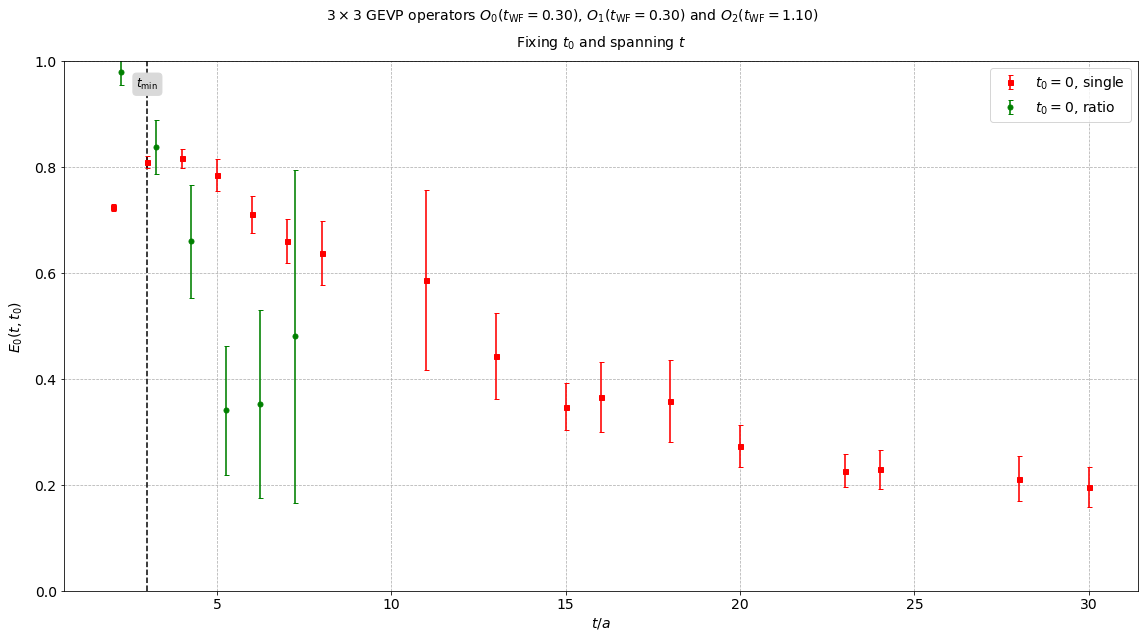

In [13]:
###############################################################
### Choose Wilson flow times for dO_i and compute dO_i dO_j ###
tW0, tW1, tW2 = 0.30, 0.30, 1.10
iW0, iW1, iW2 = int(np.around(tW0 / (WF_step * eps_WF))), int(np.around(tW1 / (WF_step * eps_WF))), int(np.around(tW2 / (WF_step * eps_WF)))
pairs = [(0, iW0), (1, iW1), (2, iW2)]    # labels for pairs (observable, corresponding t_WF)
Noss = len(pairs)

dOidOj = np.zeros((Ncnfg, Noss, Noss, T))
for tp in range(T):
    # print(f"t = {tp}")  
    for (i, WF1) in pairs:
        row = pairs.index((i, WF1))
        for (j, WF2) in pairs:
            col = pairs.index((j, WF2))
            # print(f"        :  row = {row}, ({i}, {t_WF[WF1]:.2f});  col = {col}, ({j}, {t_WF[WF2]:.2f})")
            dOidOj[:,row,col,tp] = np.mean(d_O[i,WF1] * np.roll(d_O[j,WF2], -tp, axis=1).conj(), axis=1)

##############################
### Create C_ij observable ###
obs = pyobs.observable(description=f'<dO_i(t)dO_j(0)> for (i, t_WF) = [(0, {tW0:.2f}), (1, {tW1:.2f}), (2, {tW2:.2f})]')
obs.create('Ensemble A', dOidOj.flatten(), shape=(Noss, Noss, T))   
C = pyobs.concatenate(obs[:,:,0], (obs[:,:,1:T//2]+obs[:,:,:T//2:-1])*0.5, axis=2)      # C.shape = (Noss, Noss, T//2)

####################
### Perform GEVP ###
case1 = 'single'
t_t0_0s, Eg_t0_0s = GEVP_pyobs.GEVP(C, t0=0, const=1, case=case1)   # no signal for t0 = 1,2,3

case2 = 'ratio'
t_t0_0r, Eg_t0_0r = GEVP_pyobs.GEVP(C, t0=0, const=1, case=case2)   # no signal for t0 = 1,2,3

tmin012 = max(t_min[iW0], t_min[iW1], t_min[iW2])

####################
### Plot results ###
Eg_0s, dEg_0s = Eg_t0_0s.error()

Eg_0r, dEg_0r = Eg_t0_0r.error()

fig, ax = plt.subplots(figsize=(16, 9))

plt.subplots_adjust(top    = 0.95)
plt.subplots_adjust(bottom = 0.05)
plt.subplots_adjust(left   = 0.05)
plt.subplots_adjust(right  = 0.95)

box = dict(boxstyle="round", color='#d9d9d9')
fsize = 14
ymin = 0
ymax = 1
 
plt.suptitle(rf"$3 \times 3$ GEVP operators $O_0(t_\mathrm{{WF}}={tW0:.2f})$, $O_1(t_\mathrm{{WF}}={tW1:.2f})$ and $O_2(t_\mathrm{{WF}}={tW2:.2f})$", fontsize=fsize)
plt.title(rf"Fixing $t_0$ and spanning $t$", pad=15, fontsize=fsize)

ax.errorbar(t_t0_0s, Eg_0s, yerr=dEg_0s, marker='s', markersize=5, linestyle='', capsize=2.5, label=rf'$t_0 = 0$, {case1}', color='red',  linewidth=1.6)
ax.errorbar(t_t0_0r+0.24, Eg_0r, yerr=dEg_0r, marker='o', markersize=5, linestyle='', capsize=2.5, label=rf'$t_0 = 0$, {case2}', color='green',  linewidth=1.6)

ax.vlines(x = tmin012, ymin = 0, ymax = ymax, colors = 'black',  linewidth=1.5, linestyles='--')
ax.annotate(rf"$t_\mathrm{{min}}$", (tmin012, ymax), xytext=(tmin012, ymax-0.05*ymax), ha='center', bbox=box, fontsize=fsize-2)
ax.set_ylabel(rf'$E_0(t, t_0)$', rotation=90, labelpad=10, fontsize=fsize)
ax.set_xlabel(rf'$t/a$', fontsize=fsize)

ax.legend(loc='best', fontsize=fsize)

plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
#plt.xlim([-0.1, T // 2 + 0.5])
plt.ylim([ymin, ymax])
#ax.set_yscale('log')
ax.grid(linestyle = '--', linewidth = 0.75)

fig.tight_layout()

print(f"Result for 3x3 GEVP; Fixing t0 and spanning t:\n")
print(f"case = '{case1}'  :  t0 = 0,  E_0 = {Eg_t0_0s}")
print(f"case = '{case2}'   :  t0 = 0,  E_0 = {Eg_t0_0r}")

Result for 3x3 GEVP; Fixing t0 and spanning t:

case = 'single'  :  t0 = 0,  E_0 = 0.1877(12)	0.3255(28)	0.4106(48)	0.4591(74)	0.486(11)	0.501(17)	0.504(24)	0.496(31)	0.489(42)	nan(51)

                 :  t0 = 1,  E_0 = 0.4598(44)	0.5148(67)	0.5410(96)	0.553(14)	0.556(20)	0.550(29)	0.539(36)	nan(12)	nan(62)	0.39(11)	0.314(72)	nan(58)	nan(56)	0.42(14)	0.257(75)	nan(10)	nan(19)	nan(48)	nan(45)	0.198(38)	nan(47)	0.142(26)	nan(69)	nan(42)	nan(20)	nan(20)	nan(90)	0.127(28)	0.160(38)

case = 'ratio'   :  t0 = 0,  E_0 = 0.4633(44)	0.5808(89)	0.605(16)	0.595(29)	0.576(49)	0.517(76)	0.44(11)	0.43(17)	nan(63)	nan(9.5)

                 :  t0 = 1,  E_0 = 0.5699(91)	0.593(16)	0.589(29)	0.571(54)	0.518(91)	0.47(13)	nan(97)



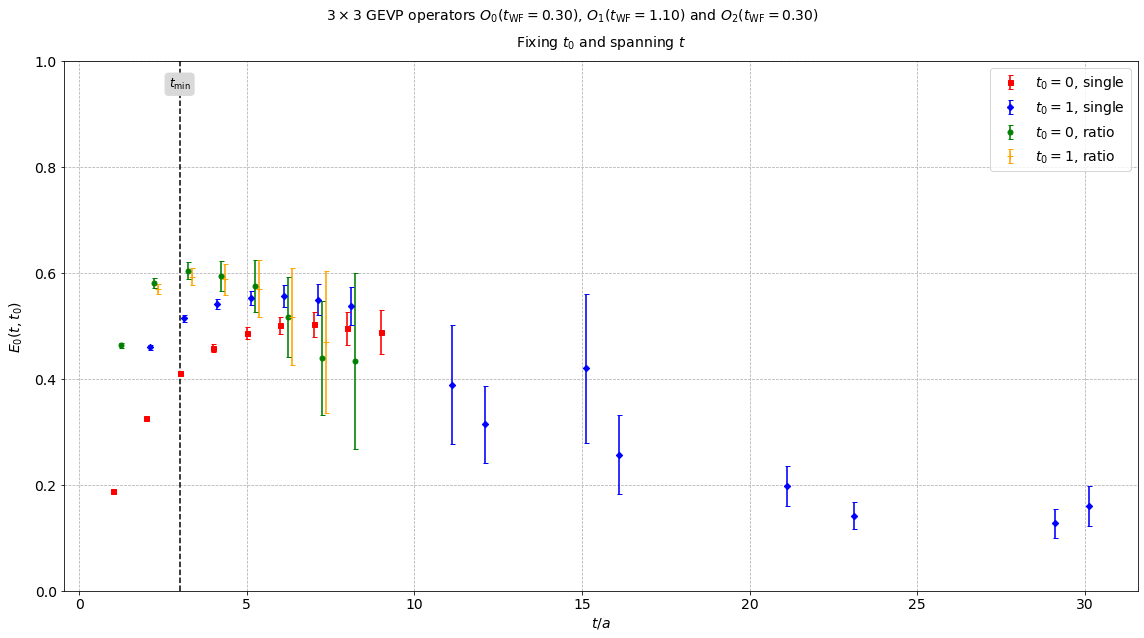

In [14]:
### choose Wilson flow times for dO_i ###
tW0, tW1, tW2 = 0.30, 1.10, 0.30
iW0, iW1, iW2 = int(np.around(tW0 / (WF_step * eps_WF))), int(np.around(tW1 / (WF_step * eps_WF))), int(np.around(tW2 / (WF_step * eps_WF)))
pairs = [(0, iW0), (1, iW1), (2, iW2)]    # labels for pairs (observable, corresponding t_WF)
Noss = len(pairs)

dOidOj = np.zeros((Ncnfg, Noss, Noss, T))
for tp in range(T):
    # print(f"t = {tp}")  
    for (i, WF1) in pairs:
        row = pairs.index((i, WF1))
        for (j, WF2) in pairs:
            col = pairs.index((j, WF2))
            # print(f"        :  row = {row}, ({i}, {t_WF[WF1]:.2f});  col = {col}, ({j}, {t_WF[WF2]:.2f})")
            dOidOj[:,row,col,tp] = np.mean(d_O[i,WF1] * np.roll(d_O[j,WF2], -tp, axis=1).conj(), axis=1)

### create C_ij observable ###
obs = pyobs.observable(description=f'<dO_i(t)dO_j(0)> for (i, t_WF) = [(0, {tW0:.2f}), (1, {tW1:.2f}), (2, {tW2:.2f})]')
obs.create('Ensemble A', dOidOj.flatten(), shape=(Noss, Noss, T))   
C = pyobs.concatenate(obs[:,:,0], (obs[:,:,1:T//2]+obs[:,:,:T//2:-1])*0.5, axis=2)      # C.shape = (Noss, Noss, T//2)
case1 = 'single'
t_t0_0s, Eg_t0_0s = GEVP_pyobs.GEVP(C, t0=0, const=1, case=case1)
t_t0_1s, Eg_t0_1s = GEVP_pyobs.GEVP(C, t0=1, const=1, case=case1)   # no signal for t0 = 2,3

case2 = 'ratio'
t_t0_0r, Eg_t0_0r = GEVP_pyobs.GEVP(C, t0=0, const=1, case=case2)
t_t0_1r, Eg_t0_1r = GEVP_pyobs.GEVP(C, t0=1, const=1, case=case2)   # no signal for t0 = 2,3

tmin012 = max(t_min[iW0], t_min[iW1], t_min[iW2])
Eg_0s, dEg_0s = Eg_t0_0s.error()
Eg_1s, dEg_1s = Eg_t0_1s.error()

Eg_0r, dEg_0r = Eg_t0_0r.error()
Eg_1r, dEg_1r = Eg_t0_1r.error()

fig, ax = plt.subplots(figsize=(16, 9))

plt.subplots_adjust(top    = 0.95)
plt.subplots_adjust(bottom = 0.05)
plt.subplots_adjust(left   = 0.05)
plt.subplots_adjust(right  = 0.95)

box = dict(boxstyle="round", color='#d9d9d9')
fsize = 14
ymin = 0
ymax = 1
 
plt.suptitle(rf"$3 \times 3$ GEVP operators $O_0(t_\mathrm{{WF}}={tW0:.2f})$, $O_1(t_\mathrm{{WF}}={tW1:.2f})$ and $O_2(t_\mathrm{{WF}}={tW2:.2f})$", fontsize=fsize)
plt.title(rf"Fixing $t_0$ and spanning $t$", pad=15, fontsize=fsize)

ax.errorbar(t_t0_0s, Eg_0s, yerr=dEg_0s, marker='s', markersize=5, linestyle='', capsize=2.5, label=rf'$t_0 = 0$, {case1}', color='red',  linewidth=1.6)
ax.errorbar(t_t0_1s+0.12, Eg_1s, yerr=dEg_1s, marker='D', markersize=4.5, linestyle='', capsize=2.5, label=rf'$t_0 = 1$, {case1}', color='blue', linewidth=1.6)
ax.errorbar(t_t0_0r+0.24, Eg_0r, yerr=dEg_0r, marker='o', markersize=5, linestyle='', capsize=2.5, label=rf'$t_0 = 0$, {case2}', color='green',  linewidth=1.6)
ax.errorbar(t_t0_1r+0.36, Eg_1r, yerr=dEg_1r, marker='+', markersize=6, linestyle='', capsize=2.5, label=rf'$t_0 = 1$, {case2}', color='orange', linewidth=1.6)

ax.vlines(x = tmin012, ymin = 0, ymax = ymax, colors = 'black',  linewidth=1.5, linestyles='--')
ax.annotate(rf"$t_\mathrm{{min}}$", (tmin012, ymax), xytext=(tmin012, ymax-0.05*ymax), ha='center', bbox=box, fontsize=fsize-2)
ax.set_ylabel(rf'$E_0(t, t_0)$', rotation=90, labelpad=10, fontsize=fsize)
ax.set_xlabel(rf'$t/a$', fontsize=fsize)

ax.legend(loc='best', fontsize=fsize)

plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
#plt.xlim([-0.1, T // 2 + 0.5])
plt.ylim([ymin, ymax])
#ax.set_yscale('log')
ax.grid(linestyle = '--', linewidth = 0.75)

fig.tight_layout()

print(f"Result for 3x3 GEVP; Fixing t0 and spanning t:\n")
print(f"case = '{case1}'  :  t0 = 0,  E_0 = {Eg_t0_0s}")
print(f"                 :  t0 = 1,  E_0 = {Eg_t0_1s}")
print(f"case = '{case2}'   :  t0 = 0,  E_0 = {Eg_t0_0r}")
print(f"                 :  t0 = 1,  E_0 = {Eg_t0_1r}")

Result for 3x3 GEVP; Fixing t0 and spanning t:

case = 'single'  :  t0 = 0,  E_0 = 0.1877(12)	0.3255(28)	0.4106(48)	0.4591(74)	0.486(11)	0.501(17)	0.503(24)	0.496(31)	0.489(43)	nan(72)	0.51(12)	nan(60)	nan(61)	0.357(45)	0.331(39)	0.322(48)	0.296(38)	0.265(24)	nan(25)	nan(26)	nan(40)	0.235(29)	0.223(29)	nan(36)	nan(27)	nan(19)	nan(15)	nan(19)	nan(33)	0.200(44)

                 :  t0 = 1,  E_0 = 0.4598(44)	0.5150(66)	0.5412(96)	0.553(14)	0.559(20)	0.554(28)	0.539(36)	nan(12)	nan(79)	0.54(13)	nan(65)	nan(66)	0.358(47)	0.328(41)	0.321(49)	0.290(37)	0.251(23)	0.237(22)	nan(28)	0.229(26)	0.226(30)	0.215(31)	nan(37)	nan(27)	nan(19)	nan(15)	nan(20)	nan(33)	0.190(44)

case = 'ratio'   :  t0 = 0,  E_0 = 0.4633(44)	0.5808(89)	0.605(16)	0.595(29)	0.576(49)	0.517(76)	0.44(11)	0.44(17)	nan(82)	nan(1.5)	nan(1.5)

                 :  t0 = 1,  E_0 = 0.5701(91)	0.594(16)	0.589(29)	0.583(50)	0.531(78)	0.44(11)	nan(1.0)



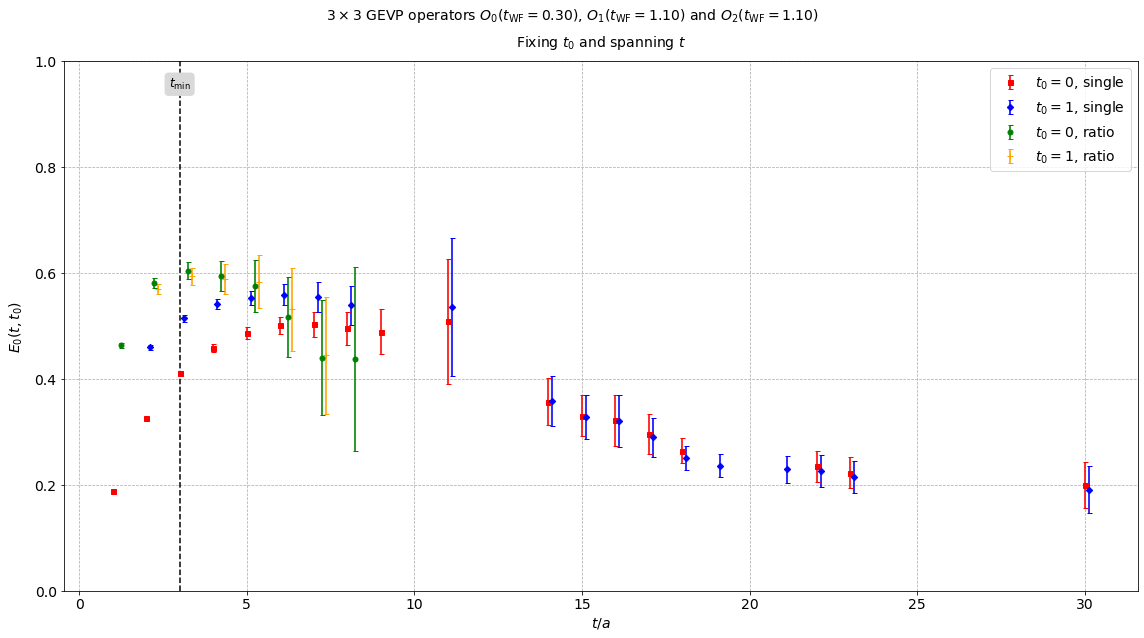

In [15]:
### choose Wilson flow times for dO_i ###
tW0, tW1, tW2 = 0.30, 1.10, 1.10
iW0, iW1, iW2 = int(np.around(tW0 / (WF_step * eps_WF))), int(np.around(tW1 / (WF_step * eps_WF))), int(np.around(tW2 / (WF_step * eps_WF)))
pairs = [(0, iW0), (1, iW1), (2, iW2)]    # labels for pairs (observable, corresponding t_WF)
Noss = len(pairs)

dOidOj = np.zeros((Ncnfg, Noss, Noss, T))
for tp in range(T):
    # print(f"t = {tp}")  
    for (i, WF1) in pairs:
        row = pairs.index((i, WF1))
        for (j, WF2) in pairs:
            col = pairs.index((j, WF2))
            # print(f"        :  row = {row}, ({i}, {t_WF[WF1]:.2f});  col = {col}, ({j}, {t_WF[WF2]:.2f})")
            dOidOj[:,row,col,tp] = np.mean(d_O[i,WF1] * np.roll(d_O[j,WF2], -tp, axis=1).conj(), axis=1)

### create C_ij observable ###
obs = pyobs.observable(description=f'<dO_i(t)dO_j(0)> for (i, t_WF) = [(0, {tW0:.2f}), (1, {tW1:.2f}), (2, {tW2:.2f})]')
obs.create('Ensemble A', dOidOj.flatten(), shape=(Noss, Noss, T))   
C = pyobs.concatenate(obs[:,:,0], (obs[:,:,1:T//2]+obs[:,:,:T//2:-1])*0.5, axis=2)      # C.shape = (Noss, Noss, T//2)
case1 = 'single'
t_t0_0s, Eg_t0_0s = GEVP_pyobs.GEVP(C, t0=0, const=1, case=case1)
t_t0_1s, Eg_t0_1s = GEVP_pyobs.GEVP(C, t0=1, const=1, case=case1)   # no signal for t0 = 2,3

case2 = 'ratio'
t_t0_0r, Eg_t0_0r = GEVP_pyobs.GEVP(C, t0=0, const=1, case=case2)
t_t0_1r, Eg_t0_1r = GEVP_pyobs.GEVP(C, t0=1, const=1, case=case2)   # no signal for t0 = 2,3

tmin012 = max(t_min[iW0], t_min[iW1], t_min[iW2])
Eg_0s, dEg_0s = Eg_t0_0s.error()
Eg_1s, dEg_1s = Eg_t0_1s.error()

Eg_0r, dEg_0r = Eg_t0_0r.error()
Eg_1r, dEg_1r = Eg_t0_1r.error()

fig, ax = plt.subplots(figsize=(16, 9))

plt.subplots_adjust(top    = 0.95)
plt.subplots_adjust(bottom = 0.05)
plt.subplots_adjust(left   = 0.05)
plt.subplots_adjust(right  = 0.95)

box = dict(boxstyle="round", color='#d9d9d9')
fsize = 14
ymin = 0
ymax = 1
 
plt.suptitle(rf"$3 \times 3$ GEVP operators $O_0(t_\mathrm{{WF}}={tW0:.2f})$, $O_1(t_\mathrm{{WF}}={tW1:.2f})$ and $O_2(t_\mathrm{{WF}}={tW2:.2f})$", fontsize=fsize)
plt.title(rf"Fixing $t_0$ and spanning $t$", pad=15, fontsize=fsize)

ax.errorbar(t_t0_0s, Eg_0s, yerr=dEg_0s, marker='s', markersize=5, linestyle='', capsize=2.5, label=rf'$t_0 = 0$, {case1}', color='red',  linewidth=1.6)
ax.errorbar(t_t0_1s+0.12, Eg_1s, yerr=dEg_1s, marker='D', markersize=4.5, linestyle='', capsize=2.5, label=rf'$t_0 = 1$, {case1}', color='blue', linewidth=1.6)
ax.errorbar(t_t0_0r+0.24, Eg_0r, yerr=dEg_0r, marker='o', markersize=5, linestyle='', capsize=2.5, label=rf'$t_0 = 0$, {case2}', color='green',  linewidth=1.6)
ax.errorbar(t_t0_1r+0.36, Eg_1r, yerr=dEg_1r, marker='+', markersize=6, linestyle='', capsize=2.5, label=rf'$t_0 = 1$, {case2}', color='orange', linewidth=1.6)

ax.vlines(x = tmin012, ymin = 0, ymax = ymax, colors = 'black',  linewidth=1.5, linestyles='--')
ax.annotate(rf"$t_\mathrm{{min}}$", (tmin012, ymax), xytext=(tmin012, ymax-0.05*ymax), ha='center', bbox=box, fontsize=fsize-2)
ax.set_ylabel(rf'$E_0(t, t_0)$', rotation=90, labelpad=10, fontsize=fsize)
ax.set_xlabel(rf'$t/a$', fontsize=fsize)

ax.legend(loc='best', fontsize=fsize)

plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
#plt.xlim([-0.1, T // 2 + 0.5])
plt.ylim([ymin, ymax])
#ax.set_yscale('log')
ax.grid(linestyle = '--', linewidth = 0.75)

fig.tight_layout()

print(f"Result for 3x3 GEVP; Fixing t0 and spanning t:\n")
print(f"case = '{case1}'  :  t0 = 0,  E_0 = {Eg_t0_0s}")
print(f"                 :  t0 = 1,  E_0 = {Eg_t0_1s}")
print(f"case = '{case2}'   :  t0 = 0,  E_0 = {Eg_t0_0r}")
print(f"                 :  t0 = 1,  E_0 = {Eg_t0_1r}")

Result for 3x3 GEVP; Fixing t0 and spanning t:

case = 'single'  :  t0 = 0,  E_0 = 0.1675(11)	0.3068(26)	0.4030(45)	0.4594(72)	0.489(11)	0.501(16)	0.501(23)	0.493(31)	0.486(40)	0.488(60)	nan(13)	0.56(24)	nan(39)	0.393(58)	0.320(20)	0.340(37)	0.36(12)	0.337(78)	nan(34)	0.251(19)	nan(33)	nan(39)	nan(40)	0.266(59)	nan(52)	nan(13)	nan(13)	nan(25)	nan(21)	0.201(31)

                 :  t0 = 1,  E_0 = 0.4462(40)	nan(48)	0.5564(93)	0.568(14)	0.565(20)	0.553(28)	0.539(35)	0.523(45)	nan(66)	nan(15)	0.315(73)	nan(53)	0.289(70)	0.205(26)	0.239(47)	0.35(12)	0.312(83)	0.214(49)	0.160(25)	nan(38)	nan(40)	0.144(29)	nan(76)	nan(50)	nan(15)	nan(15)	nan(32)	nan(21)	0.161(40)

case = 'ratio'   :  t0 = 0,  E_0 = 0.4462(40)	0.5955(84)	0.629(16)	0.606(29)	0.563(47)	0.499(72)	0.44(10)	0.43(16)	0.51(29)	nan(1.7)	nan(3.5)	nan(3.1)	nan(99)

                 :  t0 = 1,  E_0 = nan(11)	nan(30)	0.603(29)	0.553(51)	0.493(81)	0.45(12)	0.41(16)	nan(69)	1.9(1.6)	nan(1.7)	nan(1.1)	nan(1.2)



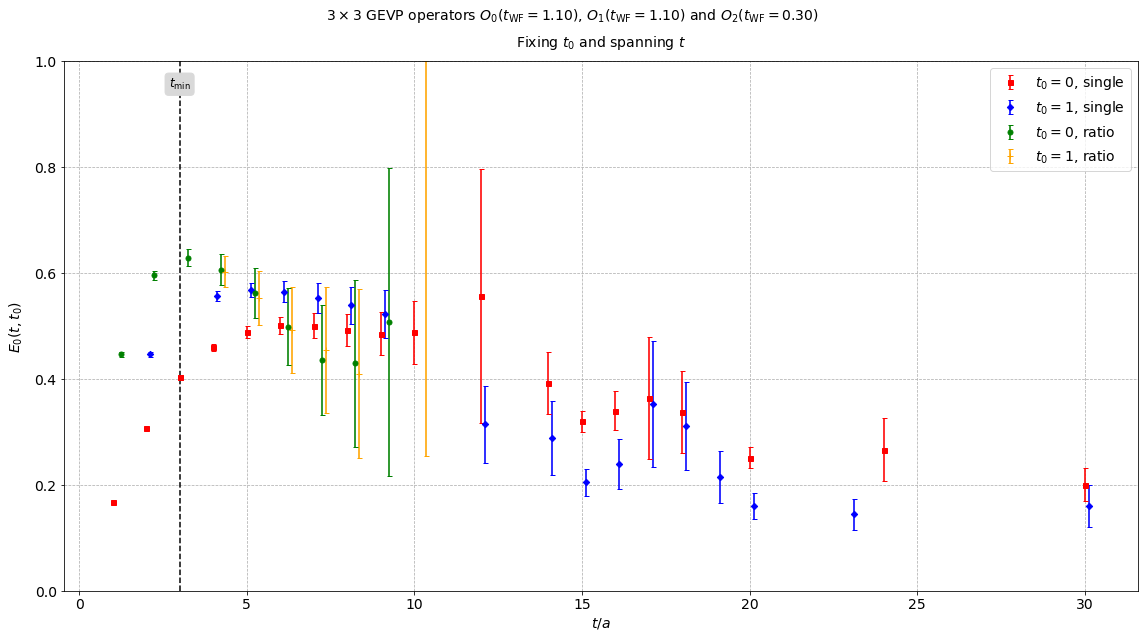

In [16]:
###############################################################
### Choose Wilson flow times for dO_i and compute dO_i dO_j ###
tW0, tW1, tW2 = 1.10, 1.10, 0.30
iW0, iW1, iW2 = int(np.around(tW0 / (WF_step * eps_WF))), int(np.around(tW1 / (WF_step * eps_WF))), int(np.around(tW2 / (WF_step * eps_WF)))
pairs = [(0, iW0), (1, iW1), (2, iW2)]    # labels for pairs (observable, corresponding t_WF)
Noss = len(pairs)

dOidOj = np.zeros((Ncnfg, Noss, Noss, T))
for tp in range(T):
    # print(f"t = {tp}")  
    for (i, WF1) in pairs:
        row = pairs.index((i, WF1))
        for (j, WF2) in pairs:
            col = pairs.index((j, WF2))
            # print(f"        :  row = {row}, ({i}, {t_WF[WF1]:.2f});  col = {col}, ({j}, {t_WF[WF2]:.2f})")
            dOidOj[:,row,col,tp] = np.mean(d_O[i,WF1] * np.roll(d_O[j,WF2], -tp, axis=1).conj(), axis=1)

##############################
### Create C_ij observable ###
obs = pyobs.observable(description=f'<dO_i(t)dO_j(0)> for (i, t_WF) = [(0, {tW0:.2f}), (1, {tW1:.2f}), (2, {tW2:.2f})]')
obs.create('Ensemble A', dOidOj.flatten(), shape=(Noss, Noss, T))   
C = pyobs.concatenate(obs[:,:,0], (obs[:,:,1:T//2]+obs[:,:,:T//2:-1])*0.5, axis=2)      # C.shape = (Noss, Noss, T//2)

####################
### Perform GEVP ###
case1 = 'single'
t_t0_0s, Eg_t0_0s = GEVP_pyobs.GEVP(C, t0=0, const=1, case=case1)
t_t0_1s, Eg_t0_1s = GEVP_pyobs.GEVP(C, t0=1, const=1, case=case1)   # no signal for t0 = 2,3

case2 = 'ratio'
t_t0_0r, Eg_t0_0r = GEVP_pyobs.GEVP(C, t0=0, const=1, case=case2)
t_t0_1r, Eg_t0_1r = GEVP_pyobs.GEVP(C, t0=1, const=1, case=case2)   # no signal for t0 = 2,3

tmin012 = max(t_min[iW0], t_min[iW1], t_min[iW2])

####################
### Plot results ###
Eg_0s, dEg_0s = Eg_t0_0s.error()
Eg_1s, dEg_1s = Eg_t0_1s.error()

Eg_0r, dEg_0r = Eg_t0_0r.error()
Eg_1r, dEg_1r = Eg_t0_1r.error()

fig, ax = plt.subplots(figsize=(16, 9))

plt.subplots_adjust(top    = 0.95)
plt.subplots_adjust(bottom = 0.05)
plt.subplots_adjust(left   = 0.05)
plt.subplots_adjust(right  = 0.95)

box = dict(boxstyle="round", color='#d9d9d9')
fsize = 14
ymin = 0
ymax = 1
 
plt.suptitle(rf"$3 \times 3$ GEVP operators $O_0(t_\mathrm{{WF}}={tW0:.2f})$, $O_1(t_\mathrm{{WF}}={tW1:.2f})$ and $O_2(t_\mathrm{{WF}}={tW2:.2f})$", fontsize=fsize)
plt.title(rf"Fixing $t_0$ and spanning $t$", pad=15, fontsize=fsize)

ax.errorbar(t_t0_0s, Eg_0s, yerr=dEg_0s, marker='s', markersize=5, linestyle='', capsize=2.5, label=rf'$t_0 = 0$, {case1}', color='red',  linewidth=1.6)
ax.errorbar(t_t0_1s+0.12, Eg_1s, yerr=dEg_1s, marker='D', markersize=4.5, linestyle='', capsize=2.5, label=rf'$t_0 = 1$, {case1}', color='blue', linewidth=1.6)
ax.errorbar(t_t0_0r+0.24, Eg_0r, yerr=dEg_0r, marker='o', markersize=5, linestyle='', capsize=2.5, label=rf'$t_0 = 0$, {case2}', color='green',  linewidth=1.6)
ax.errorbar(t_t0_1r+0.36, Eg_1r, yerr=dEg_1r, marker='+', markersize=6, linestyle='', capsize=2.5, label=rf'$t_0 = 1$, {case2}', color='orange', linewidth=1.6)

ax.vlines(x = tmin012, ymin = 0, ymax = ymax, colors = 'black',  linewidth=1.5, linestyles='--')
ax.annotate(rf"$t_\mathrm{{min}}$", (tmin012, ymax), xytext=(tmin012, ymax-0.05*ymax), ha='center', bbox=box, fontsize=fsize-2)
ax.set_ylabel(rf'$E_0(t, t_0)$', rotation=90, labelpad=10, fontsize=fsize)
ax.set_xlabel(rf'$t/a$', fontsize=fsize)

ax.legend(loc='best', fontsize=fsize)

plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
#plt.xlim([-0.1, T // 2 + 0.5])
plt.ylim([ymin, ymax])
#ax.set_yscale('log')
ax.grid(linestyle = '--', linewidth = 0.75)

fig.tight_layout()

print(f"Result for 3x3 GEVP; Fixing t0 and spanning t:\n")
print(f"case = '{case1}'  :  t0 = 0,  E_0 = {Eg_t0_0s}")
print(f"                 :  t0 = 1,  E_0 = {Eg_t0_1s}")
print(f"case = '{case2}'   :  t0 = 0,  E_0 = {Eg_t0_0r}")
print(f"                 :  t0 = 1,  E_0 = {Eg_t0_1r}")